<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
<a href="http://mng.bz/orYv">《从零开始构建大型语言模型》</a>一书的补充代码，作者：<a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>代码仓库：<a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


## 附录D：为训练循环添加高级功能

- 在本附录中，我们为训练函数添加了一些更高级的功能，这些功能在典型的预训练和微调中会用到；微调在第6章和第7章中有介绍
- 下面的三个部分讨论学习率预热、余弦衰减和梯度裁剪
- 最后一节将这些技术添加到训练函数中

- 我们首先通过重用第5章的代码来初始化一个模型：

In [1]:
from importlib.metadata import version
import torch

print("torch version:", version("torch"))


from previous_chapters import GPTModel
# If the `previous_chapters.py` file is not available locally,
# you can import it from the `llms-from-scratch` PyPI package.
# For details, see: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# E.g.,
# from llms_from_scratch.ch04 import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

torch version: 2.7.1


- 接下来，使用我们在第5章中使用的相同代码，我们初始化数据加载器：

In [2]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [3]:
from previous_chapters import create_dataloader_v1
# Alternatively:
# from llms_from_scratch.ch02 import create_dataloader_v1


# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    text_data[:split_idx],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    text_data[split_idx:],
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

## D.1 学习率预热

- 在训练像LLM这样的复杂模型时，实施学习率预热可以帮助稳定训练
- 在学习率预热中，我们逐渐将学习率从一个非常低的值（`initial_lr`）增加到用户指定的最大值（`peak_lr`）
- 这样，模型将以小的权重更新开始训练，这有助于降低训练期间大的不稳定更新的风险

In [4]:
n_epochs = 15
initial_lr = 0.0001
peak_lr = 0.01

- 通常，预热步数在总步数的0.1%到20%之间
- 我们可以将增量计算为`peak_lr`和`initial_lr`之间的差值除以预热步数

In [5]:
total_steps = len(train_loader) * n_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup
print(warmup_steps)

27


- 注意，印刷版书籍意外包含了一行遗留代码`warmup_steps = 20`，这行代码没有被使用，可以安全地忽略

In [6]:
lr_increment = (peak_lr - initial_lr) / warmup_steps

global_step = -1
track_lrs = []

optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1
    
        if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment
        else:
            lr = peak_lr
        
        # Apply the calculated learning rate to the optimizer
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])
    
        # Calculate loss and update weights
        # ...

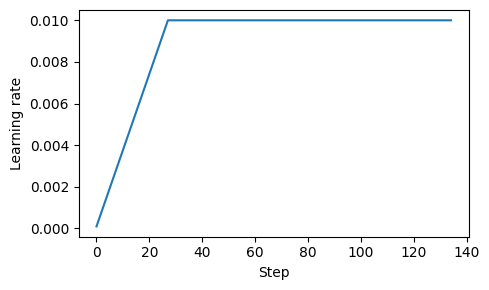

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.ylabel("Learning rate")
plt.xlabel("Step")
total_training_steps = len(train_loader) * n_epochs
plt.plot(range(total_training_steps), track_lrs)
plt.tight_layout(); plt.savefig("1.pdf")
plt.show()

## D.2 余弦衰减

- 训练复杂深度神经网络的另一种流行技术是余弦衰减，它也会在训练轮次中调整学习率
- 在余弦衰减中，学习率遵循余弦曲线，从其初始值减少到接近零，遵循半余弦周期
- 这种渐进式减少旨在随着模型开始改善其权重而减慢学习的步伐；它降低了训练进行时超调最小值的风险，这对于稳定训练的后期阶段至关重要
- 余弦衰减通常比线性衰减更受青睐，因为它在学习率调整方面提供了更平滑的过渡，但线性衰减在实践中也有使用（例如，[OLMo: Accelerating the Science of Language Models](https://arxiv.org/abs/2402.00838)）

In [8]:
import math

min_lr = 0.1 * initial_lr
track_lrs = []

lr_increment = (peak_lr - initial_lr) / warmup_steps
global_step = -1

for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1
    
        # Adjust the learning rate based on the current phase (warmup or cosine annealing)
        if global_step < warmup_steps:
            # Linear warmup
            lr = initial_lr + global_step * lr_increment  
        else:
            # Cosine annealing after warmup
            progress = ((global_step - warmup_steps) / 
                        (total_training_steps - warmup_steps))
            lr = min_lr + (peak_lr - min_lr) * 0.5 * (
                1 + math.cos(math.pi * progress))
        
        # Apply the calculated learning rate to the optimizer
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])
    
        # Calculate loss and update weights

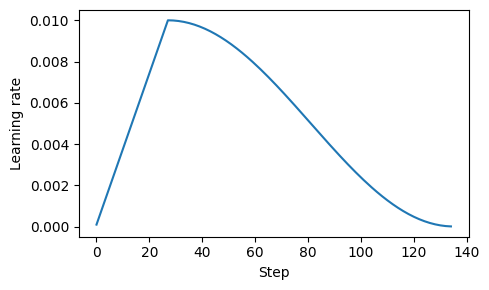

In [9]:
plt.figure(figsize=(5, 3))
plt.ylabel("Learning rate")
plt.xlabel("Step")
plt.plot(range(total_training_steps), track_lrs)
plt.tight_layout(); plt.savefig("2.pdf")
plt.show()

## D.3 梯度裁剪

- 梯度裁剪是训练LLM时用于稳定训练的另一种技术
- 通过设置阈值，超过此限制的梯度会被缩放到最大幅度，以确保反向传播期间对模型参数的更新保持在可管理的范围内
- 例如，在PyTorch的`clip_grad_norm_`方法中使用`max_norm=1.0`设置意味着梯度的范数被裁剪，使其最大范数不超过1.0
- "范数"指的是梯度向量在模型参数空间中的长度（或幅度）的度量
- 具体来说，它是L2范数，也称为欧几里得范数
- 数学上，对于具有分量$\mathbf{v} = [v_1, v_2, \ldots, v_n]$的向量$\mathbf{v}$，L2范数定义为：
$$
\| \mathbf{v} \|_2 = \sqrt{v_1^2 + v_2^2 + \ldots + v_n^2}
$$

- L2范数对矩阵的计算类似。
- 假设我们的梯度矩阵是：
$$
G = \begin{bmatrix}
1 & 2 \\
2 & 4
\end{bmatrix}
$$

- 我们想要用`max_norm`为1来裁剪这些梯度。

- 首先，我们计算这些梯度的L2范数：
$$
\|G\|_2 = \sqrt{1^2 + 2^2 + 2^2 + 4^2} = \sqrt{25} = 5
$$

- 由于$\|G\|_2 = 5$大于我们的`max_norm`值1，我们需要缩放梯度使其范数恰好为1。缩放因子计算为$\frac{max\_norm}{\|G\|_2} = \frac{1}{5}$。

- 因此，缩放后的梯度矩阵$G'$将如下所示：
$$
G' = \frac{1}{5} \times G = \begin{bmatrix}
\frac{1}{5} & \frac{2}{5} \\
\frac{2}{5} & \frac{4}{5}
\end{bmatrix}
$$

- 让我们看看这个过程的实际操作
- 首先，我们初始化一个新模型并计算训练批次的损失，就像我们在常规训练循环中所做的那样

In [10]:
from previous_chapters import calc_loss_batch
# Alternatively:
# from llms_from_scratch.ch05 import calc_loss_batch


torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

loss = calc_loss_batch(input_batch, target_batch, model, device)
loss.backward()

- 如果我们调用`.backward()`，PyTorch将计算梯度并将它们存储在每个权重（参数）矩阵的`.grad`属性中
- 让我们定义一个实用函数来基于所有模型权重计算最高梯度

In [11]:
def find_highest_gradient(model):
    max_grad = None
    for param in model.parameters():
        if param.grad is not None:
            grad_values = param.grad.data.flatten()
            max_grad_param = grad_values.max()
            if max_grad is None or max_grad_param > max_grad:
                max_grad = max_grad_param
    return max_grad

print(find_highest_gradient(model))

tensor(0.0411)


- 应用梯度裁剪后，我们可以看到最大梯度现在大幅减小了：

In [12]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
print(find_highest_gradient(model))

tensor(0.0185)


## D.4 修改后的训练函数

- 现在让我们将上面涵盖的三个概念（学习率预热、余弦衰减和梯度裁剪）添加到第5章中涵盖的`train_model_simple`函数中，以创建下面更复杂的`train_model`函数：

In [13]:
from previous_chapters import evaluate_model, generate_and_print_sample
# Alternatively:
# from llms_from_scratch.ch05 import evaluate_model, generate_and_print_samplee


ORIG_BOOK_VERSION = False


def train_model(model, train_loader, val_loader, optimizer, device,
                n_epochs, eval_freq, eval_iter, start_context, tokenizer,
                warmup_steps, initial_lr=3e-05, min_lr=1e-6):

    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    tokens_seen, global_step = 0, -1

    # Retrieve the maximum learning rate from the optimizer
    peak_lr = optimizer.param_groups[0]["lr"]

    # Calculate the total number of iterations in the training process
    total_training_steps = len(train_loader) * n_epochs

    # Calculate the learning rate increment during the warmup phase
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    for epoch in range(n_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            global_step += 1

            # Adjust the learning rate based on the current phase (warmup or cosine annealing)
            if global_step < warmup_steps:
                # Linear warmup
                lr = initial_lr + global_step * lr_increment  
            else:
                # Cosine annealing after warmup
                progress = ((global_step - warmup_steps) / 
                            (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

            # Apply the calculated learning rate to the optimizer
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr)  # Store the current learning rate

            # Calculate and backpropagate the loss
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            # Apply gradient clipping after the warmup phase to avoid exploding gradients
            if ORIG_BOOK_VERSION:
                if global_step > warmup_steps:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
            else:
                if global_step >= warmup_steps:  # the book originally used global_step > warmup_steps, which led to a skipped clipping step after warmup
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
            optimizer.step()
            tokens_seen += input_batch.numel()

            # Periodically evaluate the model on the training and validation sets
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader,
                    device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                # Print the current losses
                print(f"Ep {epoch+1} (Iter {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )

        # Generate and print a sample from the model to monitor progress
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen, track_lrs

In [14]:
import tiktoken

# Note:
# Uncomment the following code to calculate the execution time
# import time
# start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

peak_lr = 0.001  # this was originally set to 5e-4 in the book by mistake
optimizer = torch.optim.AdamW(model.parameters(), lr=peak_lr, weight_decay=0.1)  # the book accidentally omitted the lr assignment
tokenizer = tiktoken.get_encoding("gpt2")

n_epochs = 15
train_losses, val_losses, tokens_seen, lrs = train_model(
    model, train_loader, val_loader, optimizer, device, n_epochs=n_epochs,
    eval_freq=5, eval_iter=1, start_context="Every effort moves you",
    tokenizer=tokenizer, warmup_steps=warmup_steps, 
    initial_lr=1e-5, min_lr=1e-5
)

# Note:
# Uncomment the following code to show the execution time
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Iter 000000): Train loss 10.934, Val loss 10.939
Ep 1 (Iter 000005): Train loss 9.151, Val loss 9.461
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Iter 000010): Train loss 7.949, Val loss 8.184
Ep 2 (Iter 000015): Train loss 6.362, Val loss 6.876
Every effort moves you,,,,,,,,,,,,,,,,,,, the,,,,,,,,, the,,,,,,,,,,, the,,,,,,,,
Ep 3 (Iter 000020): Train loss 5.851, Val loss 6.607
Ep 3 (Iter 000025): Train loss 5.751, Val loss 6.634
Every effort moves you. "I"I and I had to the to the to the and the of the to the of the to Gisburn, and the of the the of the of the to the to the of the of the of the to the of
Ep 4 (Iter 000030): Train loss 4.617, Val loss 6.713
Ep 4 (Iter 000035): Train loss 4.280, Val loss 6.642
Every effort moves you, I was. Gisburn. Gisburn's. Gisburn. Gisburn's of the of Jack's. "I of his I had the of the of the of his of, I had been. I was.
Ep 5 (Iter 000040): Train loss 3.184, Val loss 6.321
Every effort moves you know the, an

- 查看上面的结果，我们可以看到模型开始时生成不可理解的词串，而到最后，它能够产生语法上或多或少正确的句子
- 如果我们检查它在最后写的一些段落，我们会发现它们在训练集中是逐字包含的——它只是记住了训练数据
- 注意这里的过拟合是因为我们有一个非常非常小的训练集，并且我们对它进行了如此多次的迭代
  - 这里的LLM训练主要用于教育目的；我们主要想看到模型能够学会产生连贯的文本
  - 与其花费数周或数月在大量昂贵的硬件上训练这个模型，我们加载预训练的权重

- 快速检查学习率是否按预期行为

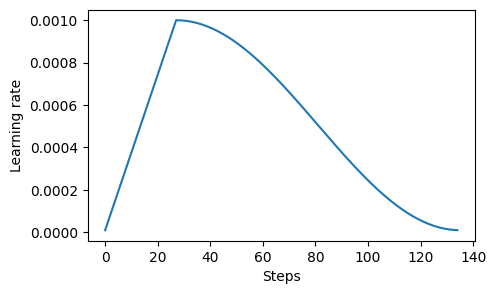

In [15]:
plt.figure(figsize=(5, 3))
plt.plot(range(len(lrs)), lrs)
plt.ylabel("Learning rate")
plt.xlabel("Steps")
plt.show()

- 快速查看损失曲线

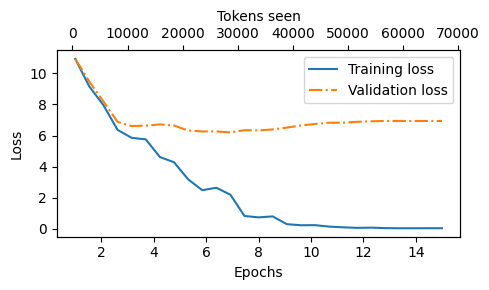

In [16]:
from previous_chapters import plot_losses
# Alternatively:
# from llms_from_scratch.ch05 import plot_losses


epochs_tensor = torch.linspace(1, n_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
plt.tight_layout(); plt.savefig("3.pdf")
plt.show()

- 注意模型在这里过拟合是因为数据集为了教育目的保持得非常小（这样代码可以在笔记本电脑上执行）
- 对于在更大数据集上进行更长的预训练运行，请参见[../../ch05/03_bonus_pretraining_on_gutenberg](../../ch05/03_bonus_pretraining_on_gutenberg)